# Generate CNN data
### We can execute the code below, copy the result to the CNN_data.txt file

In [16]:
import torch
import torch.nn as nn  # the neural network library of pytorch
from torch.nn import AdaptiveAvgPool2d
import torch.nn.functional as F
from torch.optim.lr_scheduler import ExponentialLR
from src.load_dataset import load_fashion_mnist
import re
import numpy as np
import matplotlib.pyplot as plt

In [15]:
from src.load_dataset import load_cifar10


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # first convolutionnal layer
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=7,
            kernel_size=4,
            stride=2,
            padding=1
        )

        # first pooling layer
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2, divisor_override=1)

        # second convolutionnal layer
        self.conv2 = nn.Conv2d(
            in_channels=7,
            out_channels=7,
            kernel_size=4,
            stride=2,
            padding=1
        )

        #second pooling layer
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2, divisor_override=1)

        # Flatten
        self.flat = nn.Flatten()

        # fully connected layer, output 10 classes
        self.fc = nn.Linear(7, 10)

    def forward(self, x):
        # x = F.normalize(self.flat(x), p=2, dim=1).view_as(x)
        x = self.conv1(x)
        x = self.pool1(x)
        # x = F.relu(x)
        x = self.conv2(x)
        x = self.pool2(x)
        # x = F.relu(x)
        x = self.flat(x)
        output = self.fc(x)
        return output


batch_size = 10  # the number of examples per batch
class_set = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # filter dataset
train_loader, test_loader = load_cifar10(class_set=class_set, train_dataset_number=2000, test_dataset_number=1000, batch_size=batch_size)
I = 16
device = torch.device("cpu")

network = CNN()
learning_rate = 1e-2*(0.66)  # the scale of the changes applied to the weights
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
scheduler = ExponentialLR(optimizer, gamma=0.9)
criterion = torch.nn.CrossEntropyLoss()
loss_list = []
CNN_accuracy_list = []

def train_net(network, train_loader, criterion, optimizer):
    network.train()  # put in train mode: we will modify the weights of the network
    train_loss = 0  # initialize the loss
    train_accuracy = 0  # initialize the accuracy

    # loop on the batches in the train dataset
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()  # important step to reset gradients to zero
        new_size = I
        adaptive_avg_pool = AdaptiveAvgPool2d((new_size, new_size))
        data = adaptive_avg_pool(data).to(device)
        data = data.sum(dim=1, keepdim=True)
        # Run the network and compute the loss
        output = network(data)  # we run the network on the data
        loss = criterion(output,
                         target)  # we compare output to the target and compute the loss, using the chosen loss function
        train_loss += loss.item()  # we increment the total train loss

        # !!!Here we do the learning!!!
        loss.backward()  # backpropagation: the gradients are automatically computed by the autograd
        optimizer.step()  # specific optimization rule for changing the weights (stochastic gradient descent, Adam etc)
        # and change weighs

        # Getting the prediction of the network and computing the accuracy
        pred = output.argmax(dim=1, keepdim=True)  # the class chosen by the network is the highest output
        acc = pred.eq(target.view_as(pred)).sum().item()  # the accuracy is the proportion of correct classes
        train_accuracy += acc  # increment accuracy of whole test set

    scheduler.step()
    train_accuracy /= len(train_loader.dataset)  # compute mean accuracy
    train_loss /= (batch_idx + 1)  # mean loss

    return train_loss, train_accuracy

total_params = sum(p.numel() for p in network.parameters())
print(f"Number of parameters: {total_params}")

for epoch in range(40):
    train_loss, train_accuracy = train_net(network, train_loader, criterion, optimizer)
    loss_list.append(train_loss)
    print(f'Epoch {epoch}: Loss = {train_loss:.6f}, accuracy = {train_accuracy*100:.4f} %')
    CNN_accuracy_list.append(train_accuracy*100)

Files already downloaded and verified
Files already downloaded and verified
Number of parameters: 990
Epoch 0: Loss = 2.341319, accuracy = 18.7500 %
Epoch 1: Loss = 2.124675, accuracy = 23.9500 %
Epoch 2: Loss = 2.089391, accuracy = 24.2000 %
Epoch 3: Loss = 2.073677, accuracy = 24.9000 %
Epoch 4: Loss = 2.051052, accuracy = 26.2000 %
Epoch 5: Loss = 2.033358, accuracy = 26.4500 %
Epoch 6: Loss = 2.015138, accuracy = 28.7000 %
Epoch 7: Loss = 2.011443, accuracy = 28.1500 %
Epoch 8: Loss = 2.003396, accuracy = 28.1000 %
Epoch 9: Loss = 1.978575, accuracy = 30.4000 %
Epoch 10: Loss = 1.980248, accuracy = 30.5500 %
Epoch 11: Loss = 1.967611, accuracy = 30.9000 %
Epoch 12: Loss = 1.956143, accuracy = 31.0500 %
Epoch 13: Loss = 1.943502, accuracy = 31.0500 %
Epoch 14: Loss = 1.942425, accuracy = 32.9000 %
Epoch 15: Loss = 1.933275, accuracy = 32.3500 %
Epoch 16: Loss = 1.924988, accuracy = 31.9500 %
Epoch 17: Loss = 1.918859, accuracy = 33.7500 %
Epoch 18: Loss = 1.909941, accuracy = 32.650

# Generate QCNN data
### Copy the QCNN result from our Cluster server to the QCNN_data.txt file, and import them
### Copy the QCNN T1 result from our Cluster server to the QCNN_data_T1.txt file, and import them

In [17]:
def extract_loss_and_accuracy(data):
    # Split the data into lines and filter out those that start with "Evaluation on test set"
    lines = [line for line in data.split('\n') if not line.startswith("Evaluation on test set")]

    # Join the filtered lines back into a single string
    filtered_data = '\n'.join(lines)

    loss_pattern = re.compile(r"Loss\s*=\s*([\d\.]+)")
    accuracy_pattern = re.compile(r"accuracy\s*=\s*([\d\.]+)\s*%")

    loss_values = loss_pattern.findall(filtered_data)
    accuracy_values = accuracy_pattern.findall(filtered_data)

    loss_values = [float(value) for value in loss_values]
    accuracy_values = [float(value) for value in accuracy_values]

    return loss_values, accuracy_values

with open('QCNN_data.txt', 'r') as file:
    QCNN_data = file.read()

with open('CNN_data.txt', 'r') as file:
    CNN_data = file.read()

QCNN_loss, QCNN_accuracy = extract_loss_and_accuracy(QCNN_data)
CNN_loss, CNN_accuracy = extract_loss_and_accuracy(CNN_data)
QCNN_accuracy_2d = np.reshape(QCNN_accuracy, (10, 40))
QCNN_accuracy_2d.tolist()
CNN_accuracy_2d = np.reshape(CNN_accuracy, (10, 40))
CNN_accuracy_2d.tolist()
print("We have imported our data!")

We have imported our data!


# Plot our data

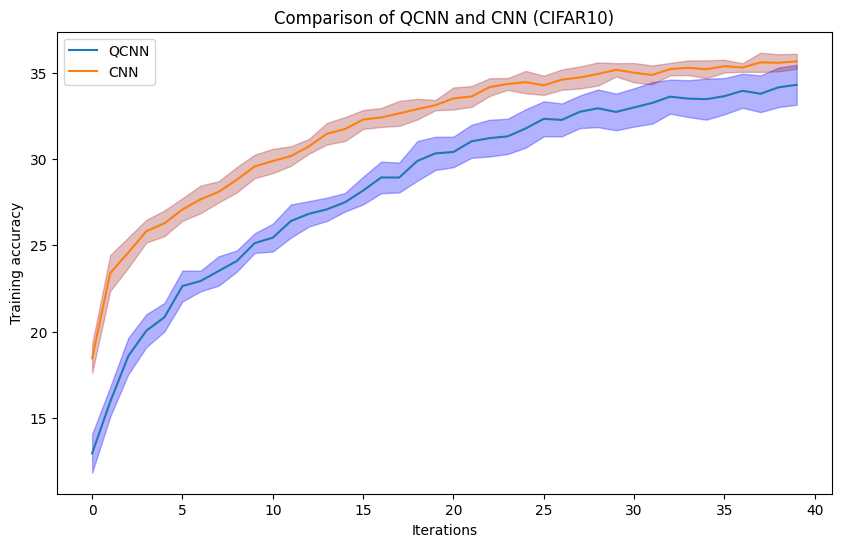

In [21]:


# Example data (replace this with your own 2D list)
# data = np.random.randn(200, 10)  # 200 iterations, 10 different runs/experiments
QCNN_data = QCNN_accuracy_2d
CNN_data = CNN_accuracy_2d
# Calculate mean and standard deviation
QCNN_mean = np.mean(QCNN_data, axis=0)
QCNN_std_dev = np.std(QCNN_data, axis=0)
CNN_mean = np.mean(CNN_data, axis=0)
CNN_std_dev = np.std(CNN_data, axis=0)


# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(QCNN_mean, label='QCNN')
plt.fill_between(range(len(QCNN_mean)), QCNN_mean - QCNN_std_dev, QCNN_mean + QCNN_std_dev, color='blue', alpha=0.3)
plt.plot(CNN_mean, label='CNN')
plt.fill_between(range(len(CNN_mean)), CNN_mean - CNN_std_dev, CNN_mean + CNN_std_dev, color='brown', alpha=0.3)
# Customize the plot
plt.xlabel('Iterations')
plt.ylabel('Training accuracy')
plt.legend()
plt.title('Comparison of QCNN and CNN (CIFAR10)')

# Show the plot
plt.show()

